In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import timm  # For Vision Transformer
import numpy as np

In [7]:
from ModifiedDataSets import get_cifar10_datasets
datasets = get_cifar10_datasets()

# Split into CNN and ViT datasets
cnn_datasets = {k.replace("cnn_", ""): v for k, v in datasets.items() if k.startswith("cnn_")}
vit_datasets = {k.replace("vit_", ""): v for k, v in datasets.items() if k.startswith("vit_")}

print("CNN datasets:", list(cnn_datasets.keys()))
print("ViT datasets:", list(vit_datasets.keys()))

CNN datasets: ['normal', 'gray', 'translate', 'patch', 'occluded']
ViT datasets: ['normal', 'gray', 'translate', 'patch', 'occluded']


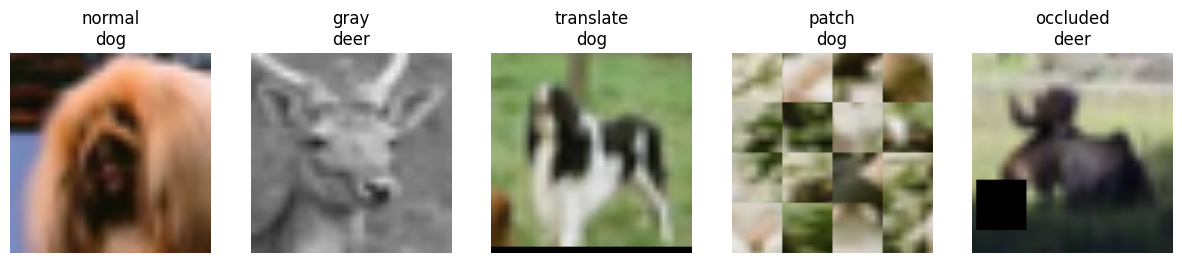

In [8]:
import random
import matplotlib.pyplot as plt

# Helper: unnormalize (to display correctly)
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))],
    std=[1/s for s in (0.229, 0.224, 0.225)]
)

# Pick one random image from each dataset
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i, (name, (train_set, test_set)) in enumerate(cnn_datasets.items()):
    if i >= 5: break  # only show 5 datasets
    idx = random.randint(0, len(test_set)-1)
    img, label = test_set[idx]

    img = unnormalize(img).permute(1, 2, 0).numpy().clip(0,1)
    axes[i].imshow(img)
    axes[i].set_title(f"{name}\n{test_set.classes[label]}")
    axes[i].axis("off")

plt.show()


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cnn_path = "resnet50_cifar10_new.pth"
vit_path = "vit_small_cifar10_new.pth"

loaded_cnn_model = torchvision.models.resnet50(pretrained=False)
loaded_cnn_model.fc = nn.Linear(loaded_cnn_model.fc.in_features, 10)
loaded_cnn_model.to(device)

loaded_vit_model = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=10)
loaded_vit_model.to(device)

try:
    print("Loading saved models...")
    loaded_cnn_model.load_state_dict(torch.load(cnn_path, map_location=device))
    loaded_vit_model.load_state_dict(torch.load(vit_path, map_location=device))
    print("Models loaded successfully!")
except FileNotFoundError:
    print("One or more model files were not found. Please ensure they are in the correct directory.")

loaded_cnn_model.eval()
loaded_vit_model.eval()

cuda


C:\Users\abdul\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\abdul\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading saved models...
Models loaded successfully!


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [10]:
from tqdm.auto import tqdm
import torch.nn as nn

# Accuracy function
def accuracy_fn(y_true, y_pred):
    return (y_true == y_pred).sum().item() / len(y_true) * 100

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Test step with tqdm
def test_step(model, data_loader, loss_fn, accuracy_fn, device=device):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        progress_bar = tqdm(data_loader, desc="Testing", leave=False)
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y).item()
            test_loss += loss
            acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            test_acc += acc

            progress_bar.set_postfix(loss=f"{loss:.4f}", acc=f"{acc:.2f}%")

    return test_loss / len(data_loader), test_acc / len(data_loader)

# ----------------------------
# Evaluate CNN and ViT on all datasets
# ----------------------------
results = {"CNN": {}, "ViT": {}}

# Build loaders for each test set
batch_size = 64

test_loaders_cnn = {name: DataLoader(test_set, batch_size=batch_size, shuffle=False)
                    for name, (_, test_set) in cnn_datasets.items()}

test_loaders_vit = {name: DataLoader(test_set, batch_size=batch_size, shuffle=False)
                    for name, (_, test_set) in vit_datasets.items()}

# Evaluate CNN
print("\n=== Evaluating CNN (ResNet-50) ===")
for name, loader in test_loaders_cnn.items():
    loss, acc = test_step(loaded_cnn_model, loader, loss_fn, accuracy_fn, device)
    results["CNN"][name] = {"loss": loss, "acc": acc}
    print(f"{name:10s} | Loss: {loss:.4f}, Acc: {acc:.2f}%")

# Evaluate ViT
print("\n=== Evaluating ViT (ViT-S/16) ===")
for name, loader in test_loaders_vit.items():
    loss, acc = test_step(loaded_vit_model, loader, loss_fn, accuracy_fn, device)
    results["ViT"][name] = {"loss": loss, "acc": acc}
    print(f"{name:10s} | Loss: {loss:.4f}, Acc: {acc:.2f}%")

# Final results dictionary
print("\n=== Summary ===")
print(results)



=== Evaluating CNN (ResNet-50) ===


normal     | Loss: 0.1943, Acc: 93.32%


gray       | Loss: 0.3842, Acc: 87.17%


translate  | Loss: 0.2566, Acc: 91.49%


patch      | Loss: 2.1319, Acc: 33.06%


occluded   | Loss: 0.4977, Acc: 82.51%

=== Evaluating ViT (ViT-S/16) ===


normal     | Loss: 0.1033, Acc: 96.60%


gray       | Loss: 0.4188, Acc: 86.74%


translate  | Loss: 0.1253, Acc: 95.90%


patch      | Loss: 1.4181, Acc: 55.80%


occluded   | Loss: 0.1264, Acc: 95.99%

=== Summary ===
{'CNN': {'normal': {'loss': 0.19428359339856038, 'acc': 93.32205414012739}, 'gray': {'loss': 0.3841600074509906, 'acc': 87.17157643312102}, 'translate': {'loss': 0.25656078660943704, 'acc': 91.49084394904459}, 'patch': {'loss': 2.1318850069288997, 'acc': 33.06130573248408}, 'occluded': {'loss': 0.4976580641262091, 'acc': 82.51393312101911}}, 'ViT': {'normal': {'loss': 0.1032878852146826, 'acc': 96.59633757961784}, 'gray': {'loss': 0.41883664787005465, 'acc': 86.74363057324841}, 'translate': {'loss': 0.12532522483094102, 'acc': 95.89968152866243}, 'patch': {'loss': 1.4180858799606373, 'acc': 55.80214968152866}, 'occluded': {'loss': 0.1264423206448555, 'acc': 95.9892515923567}}}
